In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)



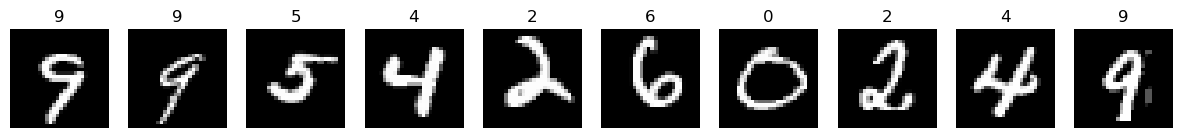

In [4]:
indices = random.sample(range(len(train_dataset)),10)
images, labels = zip(*[train_dataset[i] for i in indices])

fig,ax = plt.subplots(1,10,figsize=(15,1.5))
for img,label,axs in zip(images,labels,ax):
    axs.imshow(img.squeeze(),cmap='gray')
    axs.set_title(f'{label}')
    axs.axis('off')

plt.show()


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7,128)
        self.fc2 = nn.Linear(128,10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MnistCNN().to(device)
lossfun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


In [8]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for images,labels in train_loader:
    images,labels = images.to(device),labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = lossfun(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted==labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct/total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = lossfun(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  test_loss = running_loss / len(test_loader)
  test_accuracy = 100 * correct / total
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')



Epoch 1/10, Train Accuracy: 95.94%, Test Accuracy: 98.40%
Epoch 2/10, Train Accuracy: 98.64%, Test Accuracy: 98.73%
Epoch 3/10, Train Accuracy: 99.11%, Test Accuracy: 98.76%
Epoch 4/10, Train Accuracy: 99.31%, Test Accuracy: 98.89%
Epoch 5/10, Train Accuracy: 99.51%, Test Accuracy: 99.02%
Epoch 6/10, Train Accuracy: 99.59%, Test Accuracy: 99.04%
Epoch 7/10, Train Accuracy: 99.62%, Test Accuracy: 99.16%
Epoch 8/10, Train Accuracy: 99.78%, Test Accuracy: 99.03%
Epoch 9/10, Train Accuracy: 99.74%, Test Accuracy: 99.11%
Epoch 10/10, Train Accuracy: 99.77%, Test Accuracy: 98.92%


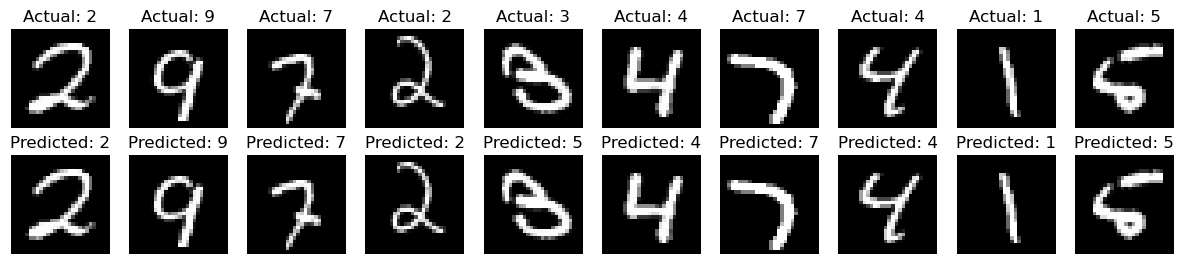

In [9]:
num_images = 10
test_images, test_labels = next(iter(test_loader))
indices = random.sample(range(len(test_images)), num_images)
selected_images = test_images[indices]
selected_labels = test_labels[indices]

selected_images = selected_images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(selected_images)
_, predicted_labels = torch.max(outputs, 1)

selected_images = selected_images.cpu()
selected_labels = selected_labels.cpu()
predicted_labels = predicted_labels.cpu()

fig, axs = plt.subplots(2, num_images, figsize=(15, 3))

for i in range(num_images):
    axs[0, i].imshow(selected_images[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Actual: {selected_labels[i].item()}')
for i in range(num_images):
    axs[1, i].imshow(selected_images[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Predicted: {predicted_labels[i].item()}')

plt.show()

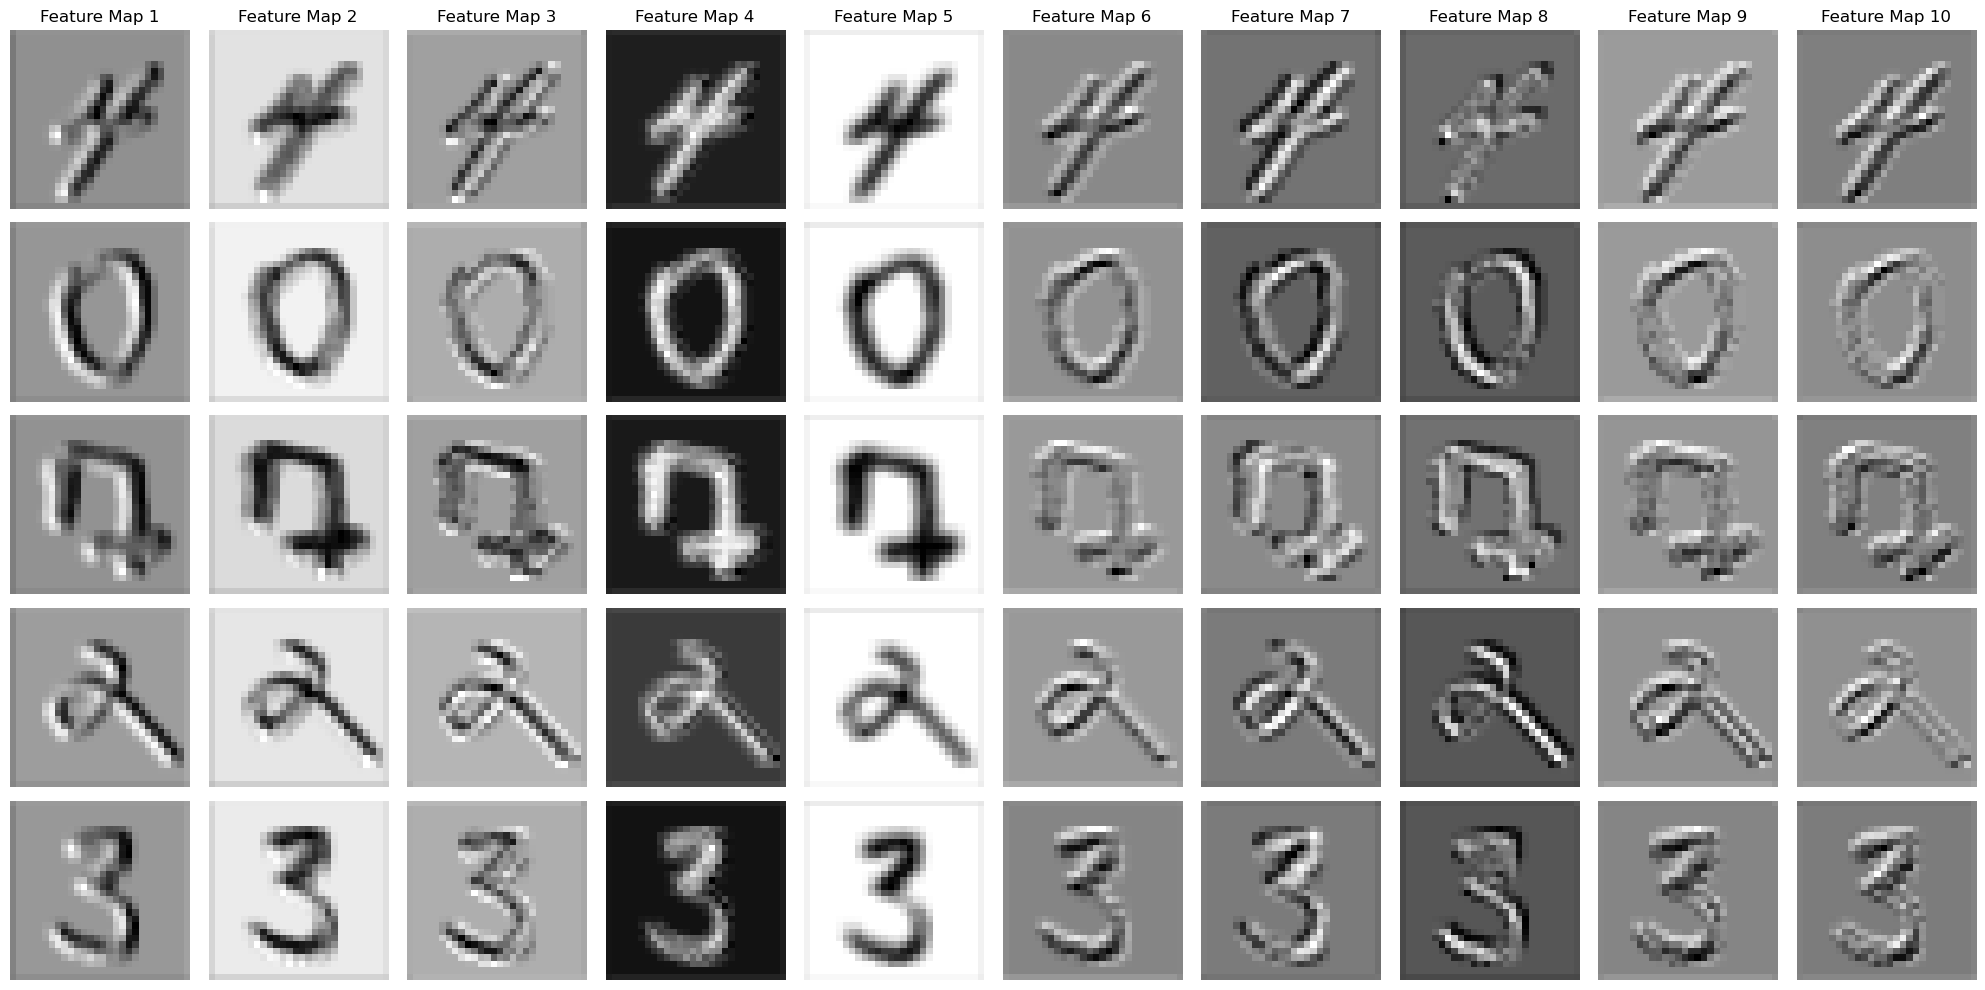

In [12]:
def visualize_feature_maps_random(model, test_loader, layer_name, num_images=5):
    model.eval()

    random_indices = random.sample(range(len(test_loader.dataset)), num_images)
    images, labels = zip(*[test_loader.dataset[i] for i in random_indices])

    layer = dict([*model.named_modules()])[layer_name]

    if isinstance(layer, nn.Conv2d):
        num_maps = layer.out_channels
    else:
        raise ValueError(f"Layer {layer_name} is not a convolutional layer")

    fig, axes = plt.subplots(num_images, 10, figsize=(10 * 2, num_images * 2))

    device = next(model.parameters()).device
    images = [image.to(device).unsqueeze(0) for image in images]

    for img_idx, image in enumerate(images):
        activations = None
        def hook(module, input, output):
            nonlocal activations
            activations = output.detach().cpu()

        handle = layer.register_forward_hook(hook)

        with torch.no_grad():
            _ = model(image)

        handle.remove()

        activations = activations.squeeze(0)

        for map_idx in range(10):
            axes[img_idx, map_idx].imshow(activations[map_idx], cmap='gray')
            axes[img_idx, map_idx].axis('off')
            if img_idx == 0:
                axes[img_idx, map_idx].set_title(f'Feature Map {map_idx+1}')

    plt.tight_layout()
    plt.show()

visualize_feature_maps_random(model, test_loader, layer_name='conv1', num_images=5)


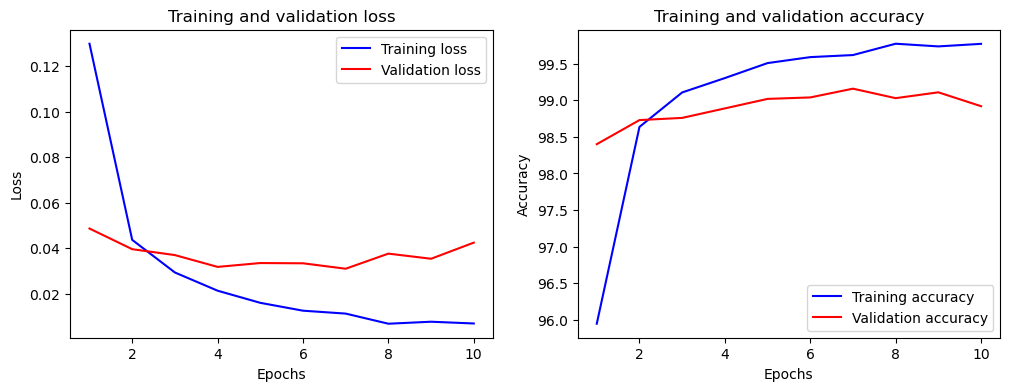

In [13]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, test_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()